In [15]:
from datetime import datetime
import numpy as np
import xgboost as xgb

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [2]:
from mb import MoodBoost
from optimizing import SubjectwiseCrossVal, MoodBoostOptimizer
from signal_pross import get_hr
from truth import IeeeGroundTruth

## 1. Process and align RGB data from video with ground truth BVP data

In [3]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')  # we only use the first trial for each subject
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )
    truth.process_bvp()
    truths.append(truth)

## 2. Train the model and validate using subject 7

In [4]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = MoodBoost(
    truths, random_state = None, loss_type = 'combined',
    n_estimators = 188, split_size = 960, learning_rate = 0.001,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    predicted_peaks_prominence = 0.28,
    true_peaks_prominence = 0.322741927274642, 
    max_depth = 6, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, finetune = True
)
mod.fit()



On batch 1 of 5:
[0]	train-rmse:0.85423	train-hr_err:1.09091	test-rmse:0.78397	test-hr_err:63.02437
[5]	train-rmse:0.85758	train-hr_err:1.09091	test-rmse:0.78592	test-hr_err:63.02437
[10]	train-rmse:0.86097	train-hr_err:0.93425	test-rmse:0.78807	test-hr_err:54.57223
[15]	train-rmse:0.86435	train-hr_err:0.93425	test-rmse:0.79049	test-hr_err:50.33725
[20]	train-rmse:0.86769	train-hr_err:0.93425	test-rmse:0.79292	test-hr_err:39.94746
[25]	train-rmse:0.87103	train-hr_err:0.77677	test-rmse:0.79538	test-hr_err:35.64556
[30]	train-rmse:0.87436	train-hr_err:0.61847	test-rmse:0.79785	test-hr_err:35.90065
[35]	train-rmse:0.87770	train-hr_err:0.45933	test-rmse:0.80034	test-hr_err:37.12309
[40]	train-rmse:0.88115	train-hr_err:0.45933	test-rmse:0.80266	test-hr_err:36.08458
[45]	train-rmse:0.88468	train-hr_err:0.77677	test-rmse:0.80492	test-hr_err:36.06428
[47]	train-rmse:0.88609	train-hr_err:0.61847	test-rmse:0.80587	test-hr_err:34.92142
Fintuning...
[0]	train-rmse:1.28767	train-hr_err:0.54912	te

## Print the model stats



MSE: 0.09981804929694552
HR error: 22.28657928306587
HR error squared: 740.4442815088006


Best test loss: 16.754459


Feature importances:


,feature,importance
0,f4,51.843216
1,f33,47.735641
2,f21,37.009895
3,f20,29.702335
4,f29,28.124027
5,f27,27.522984
6,f28,26.053051
7,f30,24.108370
8,f31,18.584049
9,f14,18.330425


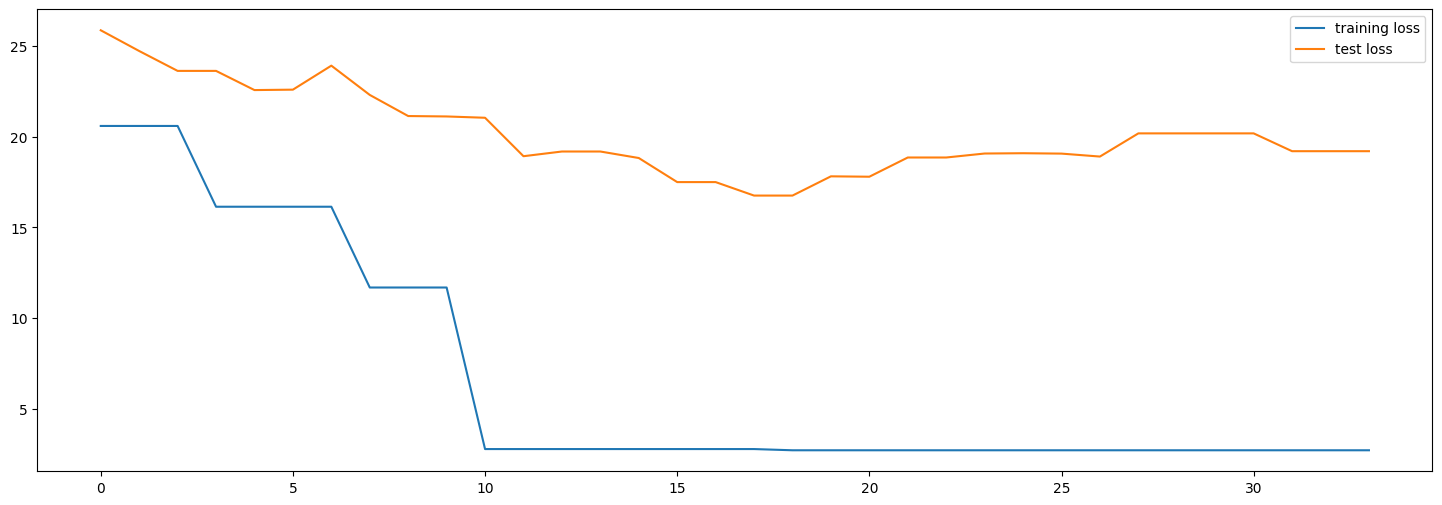

In [5]:
mse, hr_err, hr_err_sq = mod.eval()

print(f'\n\nMSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}\n\n')

mod.get_model_stats()
mod.plot_hr_loss()

## Plot the predicted signal versus its ground truth

peak memory: 267.55 MiB, increment: 0.00 MiB
Time elapsed: 0:00:00.034701


NameError: name 'get_hr' is not defined

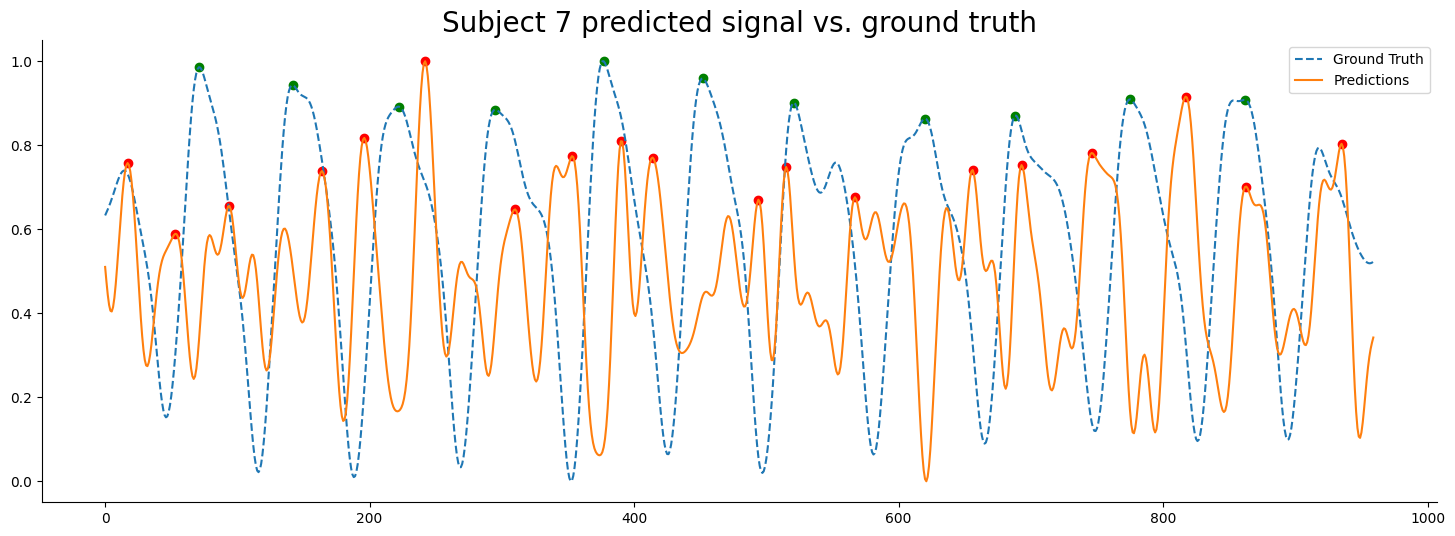

In [16]:
# beginning point from which to plot
beg = 3000
end = beg + 960  # we add 960 bc that's the period which HR error is calculated; it's also the amount of user video needed to calculate HR error (15s)

# prepare test subject data for ML, and give it the corresponding mem feats (8 mem feat, 12 skip amount)
data = test_subject_truth.prepare_data_for_ml(8, 12)

# get input data and target data
X = xgb.DMatrix(data.drop(columns = ['bvp']).to_numpy())
y = data['bvp'].to_numpy()

# get the model predictions in this method so that RAM usage is measured accurately
def measure_code_block():
    t = datetime.today()
    targ = y[beg: end]
    pred = mod.predict(X)
    pred = pred[beg: end]
    targ, pred = mod.process_signal(targ, pred, use_bandpass=True)
    elapsed_time = datetime.today() - t
    return targ, pred, elapsed_time

# measure the RAM usage of the model while also getting the predictions and processing both predictions and targets
%memit targ, pred, elapsed_time = measure_code_block()
print('Time elapsed:', elapsed_time)

# get the predicted and true peaks for each signal
pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

# create the plot
plt.plot(targ, linestyle = '--', label = 'Ground Truth')
plt.plot(pred, label = 'Predictions')
plt.legend()
plt.title(f'Subject {test_subject} predicted signal vs. ground truth', fontsize = 20)

# modify plot appearance
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

# plot the peaks
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

# compute the predicted and true HR for this block
pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

## 4. Apply cross-validation to validate performance

In [ ]:
rpm = 1
res = SubjectwiseCrossVal(
    truths, random_state = None, loss_type = 'combined', rounds_per_model = rpm,
    n_estimators = 188, split_size = 960, learning_rate = 0.001,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    predicted_peaks_prominence = 0.28,
    true_peaks_prominence = 0.322741927274642,
    max_depth = 6, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, collect = True
)



On batch 1 of 5:
[0]	train-rmse:0.95691	train-hr_err:1.37726	test-rmse:0.81041	test-hr_err:16.29343
[5]	train-rmse:0.96127	train-hr_err:1.37726	test-rmse:0.81061	test-hr_err:14.87750
[10]	train-rmse:0.96564	train-hr_err:1.37726	test-rmse:0.81083	test-hr_err:16.29343
[15]	train-rmse:0.97002	train-hr_err:1.25917	test-rmse:0.81112	test-hr_err:19.67557
[16]	train-rmse:0.97091	train-hr_err:1.25917	test-rmse:0.81118	test-hr_err:19.67557
Fintuning...
[0]	train-rmse:1.32301	train-hr_err:1.25917	test-rmse:0.81059	test-hr_err:18.29594
[5]	train-rmse:1.31702	train-hr_err:1.25917	test-rmse:0.80736	test-hr_err:14.14299
[10]	train-rmse:1.31107	train-hr_err:2.68741	test-rmse:0.80419	test-hr_err:18.82932
[12]	train-rmse:1.30870	train-hr_err:10.94850	test-rmse:0.80294	test-hr_err:21.76061


On batch 2 of 5:
[0]	train-rmse:0.50618	train-hr_err:13.50741	test-rmse:0.80337	test-hr_err:24.72026
[5]	train-rmse:0.51009	train-hr_err:17.74115	test-rmse:0.80555	test-hr_err:23.34004
[10]	train-rmse:0.51404	trai

NameError: name 'get_hrv' is not defined

## Bayesian hyperparameter optimization demonstration

In [ ]:
optimizer = MoodBoostOptimizer(truths)
result = optimizer.optimize(n_calls = 1)
print(result)